# load model

In [3]:
# %%
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
import matplotlib.pyplot as plt
import scipy

# my utilities
from model import mymodel

class myDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1) # Learning rate scheduler.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    valid_loss = []
    train_loss = []

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []
        for x, y in train_loader:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
        mean_train_loss = sum(loss_record)/len(loss_record)
        train_loss.append(mean_train_loss)
        # writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        valid_loss.append(mean_valid_loss)

        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        scheduler.step() # Update learning rate.
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}, 当前学习率: {current_lr:.6f}")

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            # torch.save(model.state_dict(), config['save_path']) # Save your best model
            # print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session. best_loss: {:.3f}'.format(best_loss))
            return
    
    print('Training finished, best loss: {:.3f}'.format(best_loss))

def standerize2d(data, mean, std):
    return (data - mean) / std

def unstanderize2d(data, mean, std):
    return data * std + mean

def predict_2matlab():
    '''
    Predict using a saved model and save predictions to a .mat file.
    '''
    mat = scipy.io.loadmat('python_file/X_set.mat')
    x = mat['X_set']
    x = torch.FloatTensor(x)  # Convert to torch tensor.
    model = mymodel(input_dim=x.shape[1], ngf=64, output_dim=(4, 64, 64), dropout=0).to('cuda') # Initialize your model.
    model_path = 'python_file/models/model.ckpt' # Path to your saved model.
    model.load_state_dict(torch.load(model_path)) # Load your saved model.

    dataset = myDataset(x)  # Create dataset.
    test_loader = DataLoader(dataset, batch_size=256, shuffle=False, pin_memory=True) # Create data loader.
    preds = predict(test_loader, model, device)  # Predict using your model.
    scipy.io.savemat('python_file/preds.mat', {'YPred': preds}) # Save predictions to a .mat file.

# %%
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 3407,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
    'n_epochs': 200,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-3,              
    'patience': 50,      # If model has not improved for this many consecutive epochs, reduce learning rate.
    'early_stop': 50,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt',  # Your model will be saved here.
    'hidden_dim': 64
}

mat_contents = scipy.io.loadmat('../dataset/dataset.mat') # Save predictions to a .mat file.
XTrain, XValidation= mat_contents['XTrain'], mat_contents['XValidation']
YTrain, YValidation = mat_contents['YTrain'], mat_contents['YValidation']

if len(YTrain.shape) == 2:  # If data is 1D, add a channel dimension.
    YTrain = YTrain[:,:,np.newaxis]
    YValidation = YValidation[:,:,np.newaxis]
print(f"""
XTrain size: {XTrain.shape}
YTrain size: {YTrain.shape} 
""")

YTrain, YValidation = torch.FloatTensor(YTrain), torch.FloatTensor(YValidation) # Convert targets to torch tensors.

# YTrain_main = YTrain.mean(dim=0) # Calculate mean of targets for standardization.
# YValidation_main = YValidation.mean(dim=0) # Calculate mean of targets for standardization.
# YTrain_std = YTrain.std(dim=0) # Calculate std of targets for standardization.
# YValidation_std = YValidation.std(dim=0) # Calculate std of targets for standardization.
# YTrain_std[YTrain_std == 0] = 1 # Avoid division by zero.
# YValidation_std[YValidation_std == 0] = 1 # Avoid division by zero.
# YTrain_standerize = standerize2d(YTrain, YTrain_main, YTrain_std) # Standardize targets.
# YValidation_standerize = standerize2d(YValidation, YValidation_main, YValidation_std) # Standardize targets.

train_dataset, valid_dataset, test_dataset = myDataset(XTrain, YTrain), \
                                            myDataset(XValidation, YValidation),\
                                            myDataset(XValidation) # Create datasets.


# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

input_dim=XTrain.shape[1]
output_dim=YTrain.shape[1:]
hidden_dim = config['hidden_dim'] 

model = mymodel(input_dim, 64, (4, 64, 64), 0).to('cuda') # Initialize your model.
model_path = './models/model.ckpt' # Path to your saved model.
model.load_state_dict(torch.load(model_path)) # Load your saved model.

preds = predict(test_loader, model, device) 
cretirion = nn.MSELoss()
loss_value = []
loss_value.append(cretirion(torch.FloatTensor(preds), YValidation))  # Calculate loss of predictions.
for c in range(4):
    a = torch.FloatTensor(preds[:,c,:,:].squeeze()) # Remove channel dimension.
    b = YValidation[:,c,:,:].squeeze() # Remove channel dimension.
    loss_value.append(cretirion(a,b))  # Calculate loss of predictions.
print(loss_value)

C:\Users\18431\AppData\Local\Temp\ipykernel_35488\2792457857.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)) # Load your 


XTrain size: (7200, 2, 14)
YTrain size: (7200, 4, 64, 64) 



100%|██████████| 4/4 [00:00<00:00, 44.19it/s]

[tensor(0.1963), tensor(0.1728), tensor(0.1522), tensor(0.2382), tensor(0.2220)]


# present

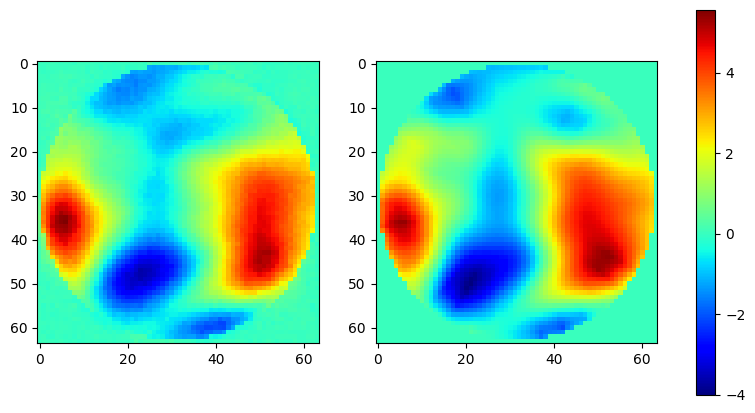

In [10]:

i = 0
c = 3
data1 = preds[i,c, :, :]
data2 = YValidation[i,c, :, :]
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) # 创建包含两个子图的图表

# 在第一个子图上显示图像
im1 = axs[0].imshow(data1, cmap='jet')
im2 = axs[1].imshow(data2, cmap='jet')

vmin = min(data1.min(), data2.min())
vmax = max(data1.max(), data2.max())
im1.set_clim(vmin, vmax)
im2.set_clim(vmin, vmax)
fig.colorbar(im1, ax=axs, orientation='vertical')

plt.show()